# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [4]:
import pickle

training_file = './traffic-signs-data/train.p'
valid_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode = 'rb') as f:
    train = pickle.load(f)
with open(valid_file, mode = 'rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode = 'rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import csv
import glob

n_train = len(y_train)
n_valid = len(y_valid)
n_test = len(y_test)
image_shape = X_train.shape[1:]

# Number of unique classes/labels in the dataset
class_labels, label_count = np.unique(y_train, return_index = True)
n_classes = len(class_labels)

print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_valid)
print("Number of testing examples: ", n_test)
print("Image data shape: ", image_shape)
print("Number of classes: ", n_classes)

Number of training examples:  34799
Number of validation examples:  4410
Number of testing examples:  12630
Image data shape:  (32, 32, 3)
Number of classes:  43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

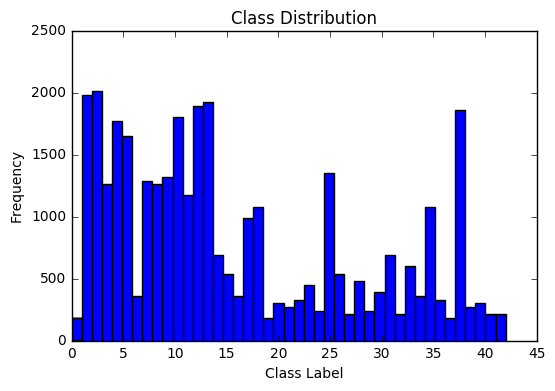

In [6]:
%matplotlib inline

class_names = []

with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        class_names.append(row[1])

# Plot the frequency of each class
def class_distribution():
    plt.hist(y_train, bins = n_classes)
    plt.title("Class Distribution")
    plt.xlabel("Class Label")
    plt.ylabel("Frequency")
    plt.show()

class_distribution()

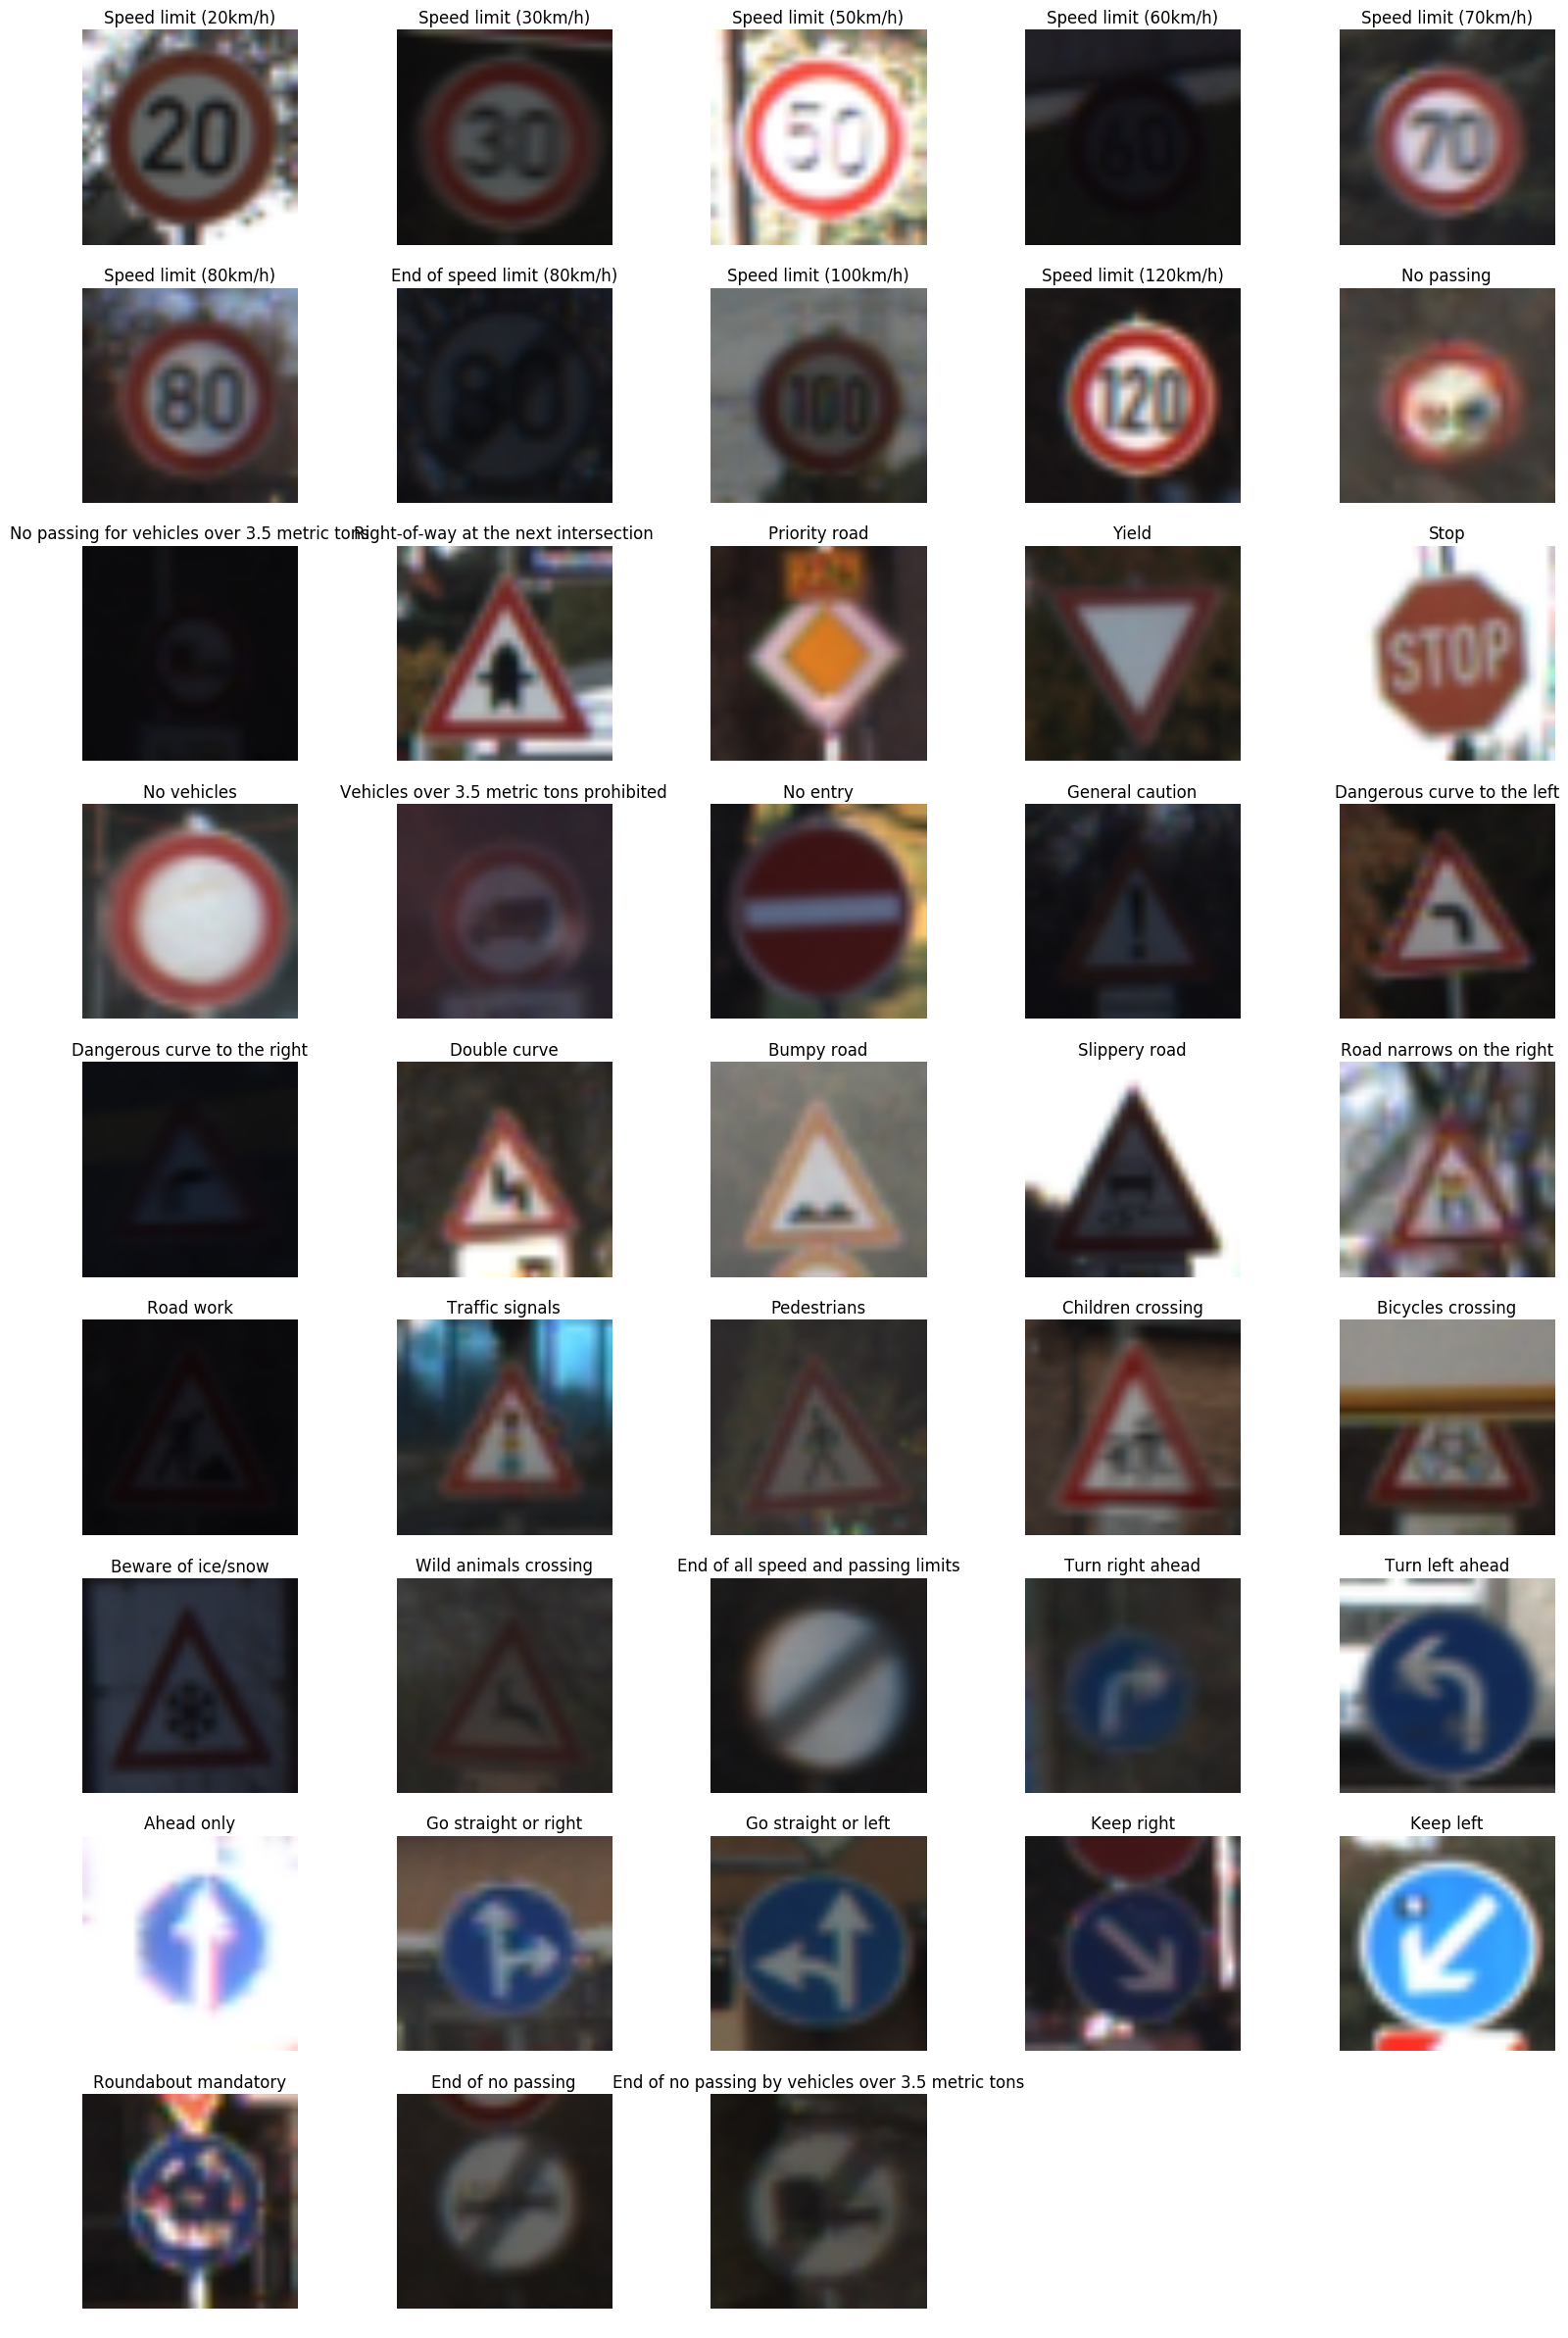

In [7]:
# Show one example from each class
plt.figure(figsize = (20,30))
for class_index in np.arange(n_classes):
    index_list = np.where(y_train == class_index)[0]
    rand_index = index_list[random.randint(0, len(index_list) - 1)]
    plt.subplot(9, 5 , class_index + 1)
    plt.title(class_names[class_index])
    plt.axis('off')
    plt.imshow(X_train[rand_index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [8]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization); histogram equalization in small blocks
def apply_clahe(image, clipLimit = 40, size = 4):
    r, g, b = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = (size, size))
    return cv2.merge([clahe.apply(r), clahe.apply(g), clahe.apply(b)])

# standardize data with numpy
def standardize(data):
    data = (data - np.mean(data)) / np.std(data)
    return data

X_train = np.array([apply_clahe(image) for image in X_train])
X_valid = np.array([apply_clahe(image) for image in X_valid])
X_test = np.array([apply_clahe(image) for image in X_test])

X_train = standardize(X_train)
X_valid = standardize(X_valid)
X_test = standardize(X_test)

print("Training Set: {}".format(len(X_train)))
print("Validation Set: {}".format(len(X_valid)))
print("Test Set: {}".format(len(X_test)))

Training Set: 34799
Validation Set: 4410
Test Set: 12630


### Model Architecture

In [99]:
# EPOCH and BATCH_SIZE affect the training speed and model accuracy
EPOCHS = 20
BATCH_SIZE = 128

# Output
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv1_b

    # RELU activation
    conv1 = tf.nn.relu(conv1)

    # Max-Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv2_b

    # RELU activation
    conv2 = tf.nn.relu(conv2)

    # Max-Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # RELU activation
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # RELU activation
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

# Features and Labels
# x is a placeholder for a batch of input images.
# y is a placeholder for a batch of output labels.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
rate = 0.001

# Training pipeline
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Evaluate how well the loss and accuracy of the model for a given dataset.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset: offset + BATCH_SIZE], y_data[offset: offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [100]:
# Train the Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset: end], y_train[offset: end]
            sess.run(training_operation, feed_dict = {x: batch_x, y: batch_y})

        train_accuracy = evaluate(X_train, y_train)
        valid_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i + 1))
        print("Training Accuracy = {:.3f} / Validation Accuracy = {:.3f}".format(train_accuracy, valid_accuracy))
        print()
    softmax = tf.nn.softmax(logits)
    top_k = tf.nn.top_k(softmax, k = 5)
    saver.save(sess, './cnn-traffic-sign')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.941 / Validation Accuracy = 0.892

EPOCH 2 ...
Training Accuracy = 0.974 / Validation Accuracy = 0.925

EPOCH 3 ...
Training Accuracy = 0.986 / Validation Accuracy = 0.940

EPOCH 4 ...
Training Accuracy = 0.987 / Validation Accuracy = 0.942

EPOCH 5 ...
Training Accuracy = 0.995 / Validation Accuracy = 0.949

EPOCH 6 ...
Training Accuracy = 0.996 / Validation Accuracy = 0.948

EPOCH 7 ...
Training Accuracy = 0.998 / Validation Accuracy = 0.955

EPOCH 8 ...
Training Accuracy = 0.997 / Validation Accuracy = 0.950

EPOCH 9 ...
Training Accuracy = 0.993 / Validation Accuracy = 0.942

EPOCH 10 ...
Training Accuracy = 0.995 / Validation Accuracy = 0.952

EPOCH 11 ...
Training Accuracy = 0.997 / Validation Accuracy = 0.949

EPOCH 12 ...
Training Accuracy = 0.990 / Validation Accuracy = 0.936

EPOCH 13 ...
Training Accuracy = 0.995 / Validation Accuracy = 0.949

EPOCH 14 ...
Training Accuracy = 0.997 / Validation Accuracy = 0.951

EPOCH 15 ...
Tra

In [101]:
# Test the Model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.936


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

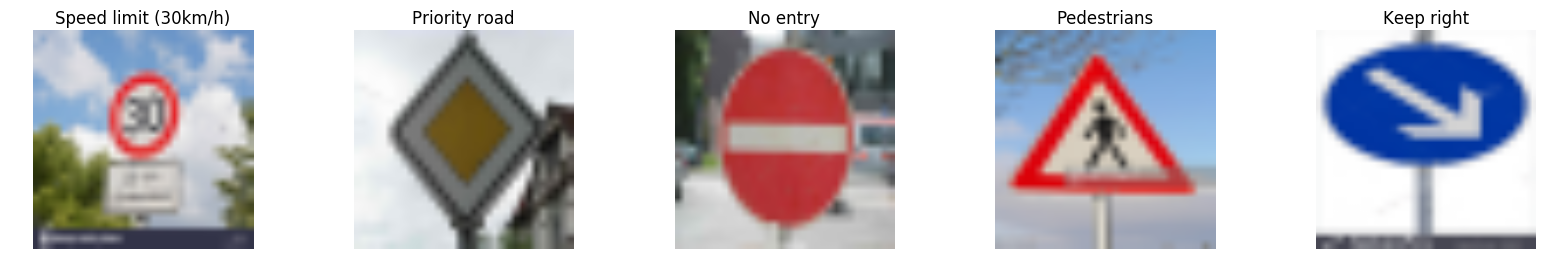

In [102]:
labels = np.array([1, 12, 17, 27, 38])
i = 0
pics = np.zeros(shape = [len(labels), 32, 32, 3], dtype = np.uint8)
converted_pics = np.zeros_like(pics)

plt.figure(figsize = (20,30))
for image in glob.glob('./sign_samples/*.jpg'):
    sign = cv2.imread(image)
    dim = (32, 32)
    pics[i] = cv2.resize(sign, dim, interpolation = cv2.INTER_AREA)
    b, g, red = cv2.split(pics[i])
    converted_pics[i] = cv2.merge([red, g, b])
    plt.subplot(9, 5, i + 1)
    plt.title(class_names[labels[i]])
    plt.imshow(converted_pics[i])
    plt.axis('off')
    i += 1

### Predict the Sign Type for Each Image

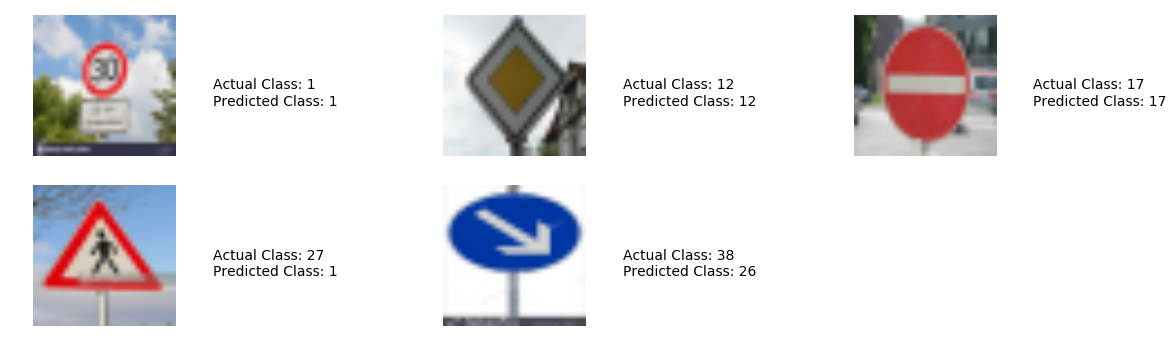

In [103]:
standardized_converted_pics = np.array([apply_clahe(image) for image in converted_pics])
standardized_converted_pics = standardize(standardized_converted_pics)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_top_k = sess.run(top_k, feed_dict = {x: standardized_converted_pics})
 
plt.figure(figsize = (15,15))
for i in range(len(converted_pics)):
    plt.subplot(7, 3, 1 + i)
    plt.text(40, 20, "Actual Class: {0}\nPredicted Class: {1}".format(labels[i], test_top_k[1][i][0]))
    plt.axis('off')
    plt.imshow(converted_pics[i])

### Analyze Performance

In [104]:
### Calculate the accuracy for the five images from the web
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    sample_accuracy = evaluate(standardized_converted_pics, labels)
    print("Sample Accuracy: {:.3f}".format(sample_accuracy))

Sample Accuracy: 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [105]:
### Print out the top five softmax probabilities for the predictions on the traffic sign images found on the web
print("Top 5 Softmax Probabilities: {}".format(test_top_k[0]))
print()
print("Corresponding Classes: {}".format(test_top_k[1]))

Top 5 Softmax Probabilities: [[  6.55337870e-01   3.36224556e-01   7.13639474e-03   1.18550577e-03
    8.92776952e-05]
 [  1.00000000e+00   4.98325322e-15   1.60059879e-17   1.03501818e-17
    8.63603277e-18]
 [  9.99967933e-01   1.50648957e-05   9.20269122e-06   5.98549605e-06
    1.18648688e-06]
 [  7.57741630e-01   2.42236361e-01   2.01325856e-05   1.22295432e-06
    2.46325925e-07]
 [  6.94135010e-01   1.19683430e-01   6.12862967e-02   5.85609674e-02
    5.63495792e-02]]

Corresponding Classes: [[ 1 12 25 31  4]
 [12  9 42 40 10]
 [17 15 14 13  1]
 [ 1 18  0 24 39]
 [26 10 13 12 11]]
